In [68]:
import numpy  as np
import pandas as pd
import random
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# Сслабая локализация с помощью скользящего окна

## Создание модели классификации

### Подготовка датасета

In [19]:
# Загрузка датасета
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255

###  Визуализация нескольких образцов из MNIST

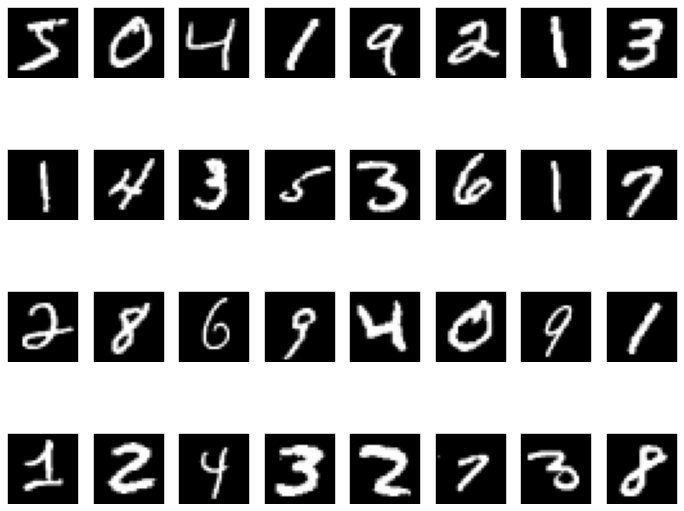

In [20]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(12, 10))
    for some_sample in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, some_sample+1)
        ax.imshow(some_samples[some_sample,:,:,0], cmap="gray")
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_some_samples(x_train[:32])

### Аугментация: добавление образцов класса "фон"

Для задач локализации нам необходимо добавить дополнительный класс "фон", который обозначает "отсутствие цифры". Индекс этого 11-го класса будет "10" (так как классы нумеруются с нуля).

Однако, недостаточно просто взять черную картинку и использовать её как образец "фона". Если в скользящее окно попадает небольшой кусочек цифры, это тоже должно означать "отсутствие цифры".

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [25%, 75%].

Так как при таком подходе у нас будут автоматически получаться абсолютно чёрные картинки (где цифра после сдвига ушла за пределы картинки), нам не нужно отдельно генерировать чисто чёрные картинки для класса "фон".

Затем визуализируем несколько образцов.

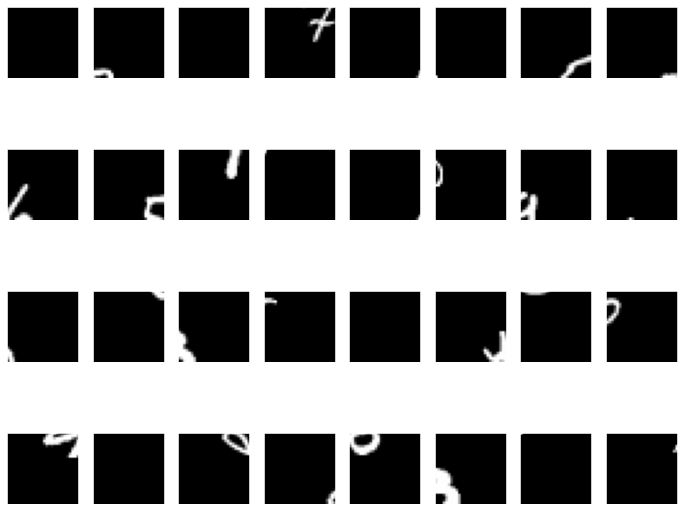

In [21]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

x_train_bg = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
y_train_bg = np.ones((bg_samples,), dtype=np.int32)*10

src_idxs = random.choices(range(x_train.shape[0]), k=bg_samples)

sh = x_train.shape[1]
sw = x_train.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = x_train[src_idxs[i], ...]

    x_train_bg[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(x_train_bg[:32, ...])

### Аугментация: добавление образцов исходных классов цифр

Для более наглядной локализации необходимо также добавить образцы с незначительными смещениями. Если цифра не строго по центру, но всё равно попала в окно, значит это окно надо классифицировать как цифру.

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [0, 25%].

Затем визуализируем несколько образцов.

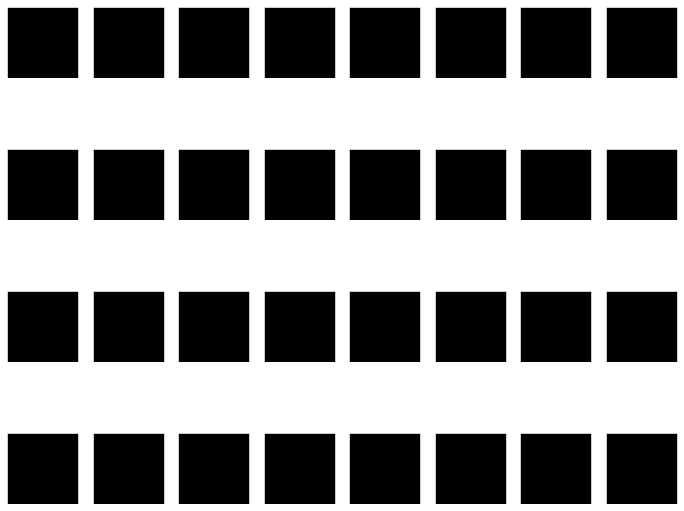

In [22]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

x_train_sh = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
y_train_sh = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(x_train.shape[0]), sh_samples)

sh = x_train.shape[1]
sw = x_train.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = x_train[src_idxs[i], ...]

    x_train_sh[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    x_train_sh[i] = y_train[src_idxs[i]]

plot_some_samples(x_train_sh[:32, ...])

### Объединение исходного датасета MNSIT и двух новых сгенерированных

In [23]:
x_train = np.concatenate((x_train, x_train_bg, x_train_sh), axis=0)
y_train = np.concatenate((y_train, y_train_bg, y_train_sh), axis=0)

### Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом "фон".
Далее мы будем применять этот классификатор для задачи слабой локализации.

In [24]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 206s 63ms/step - loss: 0.0979 - accuracy: 0.9642
Epoch 2/3
3282/3282 [==============================] - 210s 64ms/step - loss: 0.0644 - accuracy: 0.9729
Epoch 3/3
3282/3282 [==============================] - 211s 64ms/step - loss: 0.0600 - accuracy: 0.9741


In [26]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0337 - accuracy: 0.9888


[0.03373135253787041, 0.9887999892234802]

## Слабая локализация с помощью скользящего окна
Теперь у нас есть обученный классификатор, который мы можем применить для решения задачи слабой локализации.

Для начала сгенерируем тестовое изображение для задачи локализации, а затем применим для него подход скользящего окна (построим тепловые карты).

Чтобы построить тепловые карты, нам необходимо применить классификатор для различных участков входного изображения (в режиме скользящего окна) и записать ответ (распределение вероятностей) в соответствующий пиксель тензора тепловых карт

### Получение входного изображения для локализации



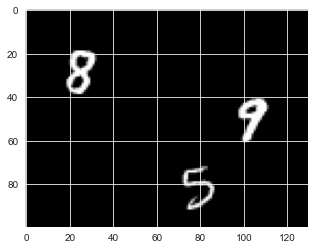

In [62]:
if True: # Сгенерировать случайное изображение

    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = x_test[random.randint(0, x_test.shape[0])]
        img = add_digit(img, digit)

else: # Загрузить готовое изображение 'digits.png'

    INPUT_IMAGE_FPTAH = 'img/digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)

# Превращение входной картинки в RGB
# (для визуализации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Подготовка буфера для тепловых карт

Буфер тепловых карт будет являться трёхмерным тензором. Первые два измерения - пространственные, третье измерение - ответственно за классы, который у нас 11. Другими словами у нас есть 11 двумерных тепловых карт, ответственных за каждый отдельный класс. Значения в тепловой карте будут в диапазоне [0, 1], что означает вероятность принадлежности данного пикселя к тому или иному классу. Эти вероятности мы будем брать из выхода классификатора.

Пространственные размерности тепловых карт будут меньше, чем входное изображение. Они будут соответствовать тому, сколько раз можно "уложить" скользящее окно во входном изображении (от края до края).

In [63]:
inp_shape = (x_train.shape[1], x_train.shape[2]) # размер входа для классификатора

heatmaps = np.zeros((
    img.shape[0] - inp_shape[0] + 1,
    img.shape[1] - inp_shape[1] + 1,
    NUM_CLASSES))

### Пример применения классификатора
В этом примере кода мы берем кусочек входной картинки (размером 28x28) из левого верхнего угла, подаём его в классификатор, получем вектор распределения вероятностей и записываем этот вектор в соответствующую позицию в тепловых картах

Кроме того, здесь используется магическая функция %%time, которая замеряет время работы данной ячейки

In [64]:
%%time

window = img[0:inp_shape[0], 0:inp_shape[1], :]
pred = model.predict(window[None, ...])[0, ...]
heatmaps[0, 0, :] = pred

1/1 [==============================] - 0s 29ms/step
CPU times: total: 78.1 ms
Wall time: 72 ms


### Запуск классификатора в режиме скользящего окна

In [65]:
%%time

for i in range(heatmaps.shape[0]):
    for j in range(heatmaps.shape[1]):
        window = img[i:i+inp_shape[0], j:j+inp_shape[1], :]
        heatmaps[i,j,:] = model.predict(window[None, ...])[0, ...]

1/1 [==============================] - 0s 48ms/step
CPU times: total: 7min 17s
Wall time: 7min 23s


### Расширение тепловых карт

Далее для наглядности будем накладывать тепловые карты на исходное изображение, чтобы увидеть, где что нашлось. Но так как тепловые карты имеют меньший размер по сравнению со входом, их надо увеличить. Будем расширять карты до размера входной картинки за счёт паддинга

In [66]:
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)

heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Визуализация тепловых карт для разных классов

Визуализируем тепловые карты, соответствующие разным классам, наложенные на исходное изображение

Heatmap for class: 0


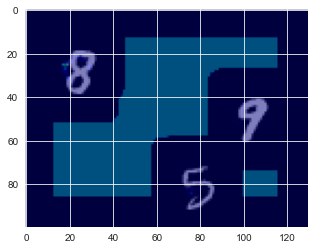

Heatmap for class: 1


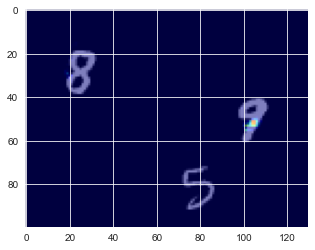

Heatmap for class: 2


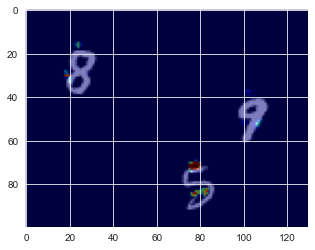

Heatmap for class: 3


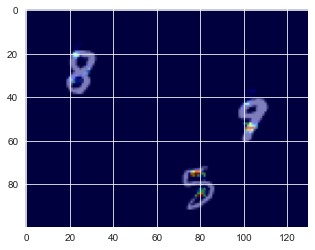

Heatmap for class: 4


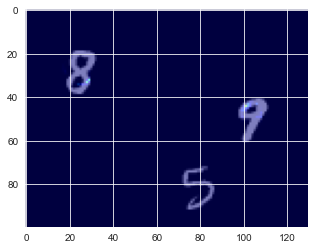

Heatmap for class: 5


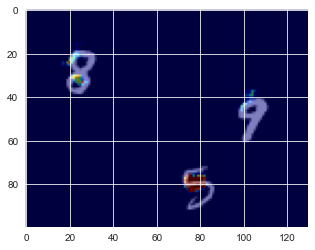

Heatmap for class: 6


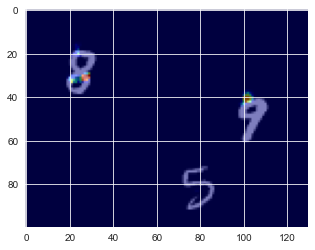

Heatmap for class: 7


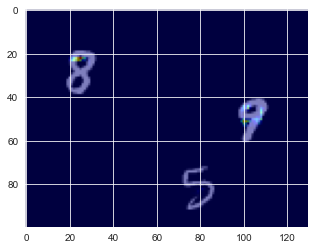

Heatmap for class: 8


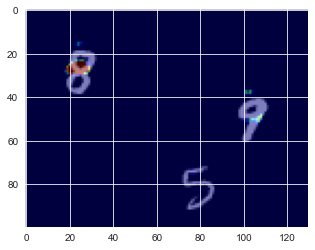

Heatmap for class: 9


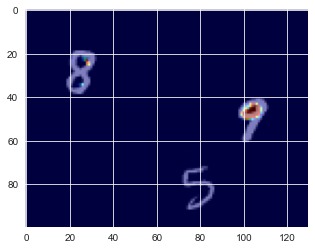

Heatmap for class: 10


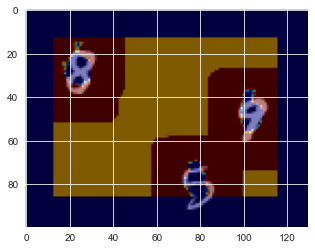

In [67]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)
    plt.show()

# Локализация с помощью полносверточной нейронной сети(FCN)

## Создание модели классификации

### Подготовка датасета

Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интесивности: float32 в диапазоне [0, 1]

In [76]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

### Визуализация нескольких образцов из MNIST
Визуализируем несколько образцов из оригинального датасета MNIST

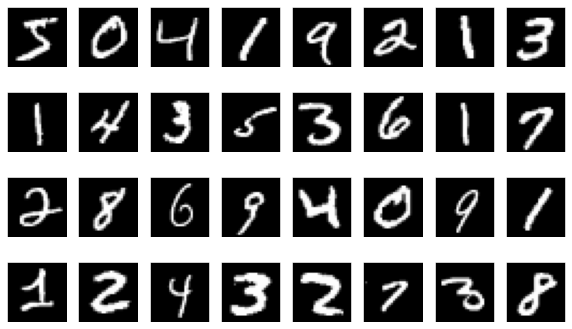

In [77]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_some_samples(train_x[:32, ...])

### Аугментация: добавление образцов класса "фон"
Так же, как и раньше, нам понадобятся дополнительные образцы из класса "фон". Сгенерируем их тем же способом, что и раньше.

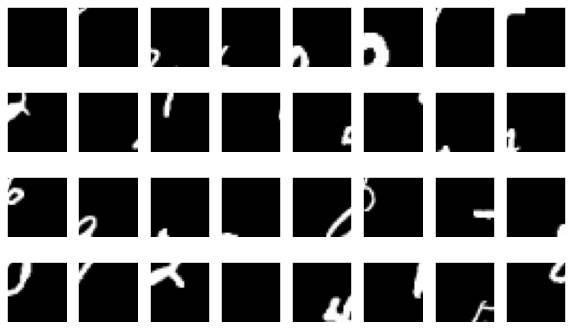

In [78]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.ones((bg_samples,), dtype=np.int32)*10

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    bg_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

### Аугментация: добавление образцов исходных классов цифр
Так же, как и раньше, нам понадобятся дополнительные образцы цифр с небольшими смещениями. Сгенерируем их тем же способом, что и раньше.

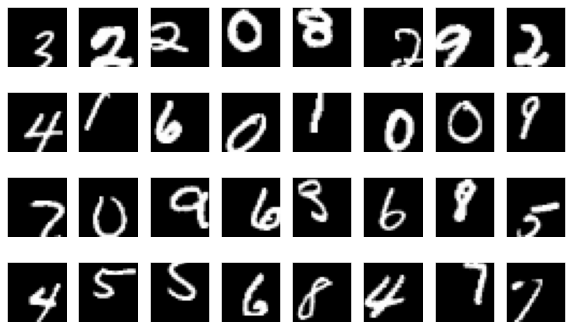

In [79]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]

plot_some_samples(sh_train_x[:32, ...])

### Объединение исходного датасета MNSIT и двух новых сгенерированных
Получаем финальные train и test датасеты, содержащие исходные и новые сгенерированные данные (конкатенируем всё по нулевому измерению)

In [80]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

### Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом "фон". Далее мы будем сконвертируем этот классификатор в FCN и применим для задачи слабой локализации.

In [83]:
NUM_CLASSES = 11
NUM_EPOCHS = 1
BATCH_SIZE = 128

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [84]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

1641/1641 [==============================] - 1854s 1s/step - loss: 0.1160 - accuracy: 0.9643


In [85]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 38s 122ms/step - loss: 0.0369 - accuracy: 0.9870


[0.03688802570104599, 0.9869999885559082]

## Слабая локализация с помощью FCN
Теперь у нас есть обученный классификатор. Нам лишь остаётся конвертировать его в FCN  и применить эту FCN для задачи локализации -- получить тепловые карты в один проход.

Конвертация в FCN будет происходить в два этапа: сначала мы создадим целевую архитектуру FCN со случайными параметрами (весами), а затем скопируем соответствующие параметры (веса) из классификатора в FCN.

### Получение входного изображения для локализации

Можно сгенерировать случайное изображение с несколькими случайными цифрами из тестового множества

А можно загрузить готовое изображение digits.png

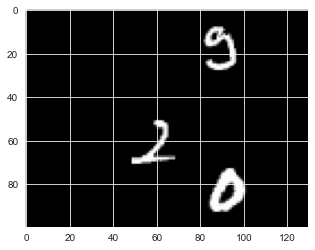

In [100]:
if True: # Сгенерировать случайное изображение

    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)

else: # Загрузить готовое изображение 'digits.png'

    INPUT_IMAGE_FPTAH = 'digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)

# Превращение входной картинки в RGB
# (для визуалзации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Создание FCN модели
Создадим модель FCN. Она очень похожа на классификационную модель, но все полносвязные слои здесь заменены на свёрточные. Все кроме первого Dense слоя заменены на свёртки 1x1 (в нашем случае это лишь последний слой, так как их всего два). А первый Dense слой заменён на свёртку 7x7

Далее мы будем копировать в эту FCN модель параметры (веса) из обученной классификационной модели.
Для того, чтобы в такой keras модели инициализировались слои (куда мы будем что-то копировать), нужно выполнить метод `build(shape)`. `shape` - желаемый размер входного тензора в нейросеть. `None` означает, что батч-сайз и пространственные размеры могут быть произвольными (ведь слои в нашей FCN никак не зависят от размера входа), а вот количество каналов (1) важно, так как оно участвует в определении размеров параметров первого свёрточного слоя в модели.

In [101]:
model_fcn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='valid'),
    tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax', padding='valid'),
])

model_fcn.build((None, None, None, 1))

### Список слоёв исходной модели
Для того, чтобы скопировать параметры классификационной сети в FCN сеть, нужно посмотреть, где эти параметры находятся (как до них добраться). Для этого распечатаем список слоёв исходной и новой модели.

In [102]:
for idx, layer in enumerate(model.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A0A2802B0>
1 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A0A282FB0>
2 ==> <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025A0A281390>
3 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A0A282E60>
4 ==> <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025A02B69D80>
5 ==> <keras.layers.reshaping.flatten.Flatten object at 0x0000025A000E4F40>
6 ==> <keras.layers.core.dense.Dense object at 0x0000025A02B6BA60>
7 ==> <keras.layers.core.dense.Dense object at 0x0000025A02B68370>


### Список слоёв новой FCN модели

In [103]:
for idx, layer in enumerate(model_fcn.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A14B8B310>
1 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A14B8BA60>
2 ==> <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025A14B8B9D0>
3 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A14B8BAC0>
4 ==> <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025A14B89870>
5 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A14B8B880>
6 ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A14B89B40>


### Копирование параметров из исходной модели
Нас интересуют только полносвязные и свёрточные слои, так как только у них есть обучаемые параметры.
У каждого такого слоя есть тензоры `kernel` и `bias`, которые означают веса и биас соответственно. В случае полносвязного слоя веса это матрица, а в случае свёрточного - четырёхмерный тензор с ядрами свёрток.

Первые два свёрточных слоя копируем как есть, без изменений.

А вот для двух полносвязных слоёв нужно применить reshape, чтобы скопировать веса из них в новые свёрточные слои.

In [104]:
model_fcn.layers[0].kernel = model.layers[0].kernel
model_fcn.layers[0].bias = model.layers[0].bias
model_fcn.layers[1].kernel = model.layers[1].kernel
model_fcn.layers[1].bias = model.layers[1].bias
model_fcn.layers[3].kernel = model.layers[3].kernel
model_fcn.layers[3].bias = model.layers[3].bias
model_fcn.layers[5].kernel = tf.reshape(model.layers[6].kernel, (7, 7, 128, 256))
model_fcn.layers[5].bias = model.layers[6].bias
model_fcn.layers[6].kernel = tf.reshape(model.layers[7].kernel, (1, 1, 256, 11))
model_fcn.layers[6].bias = model.layers[7].bias

### Запуск FCN для входной картинки и получение тепловых карт

Теперь наша FCN модель готова к слабой локализации. На вход можно сразу подавать входное изображение (не забыв приклеить дополнительное измерение для батча `img[None, ...]`)
Предсказание делается в один проход, что должно быть существенно быстрее метода скользящего окна.

In [105]:
%%time

heatmap = model_fcn.predict(img[None,])[0,]

1/1 [==============================] - 0s 180ms/step
CPU times: total: 266 ms
Wall time: 243 ms


### Расширение тепловых карт
Теперь нам понадобится сделать расширение тепловых карт до размеров исходной картинки.

Так как мы использовали пулинги, выходные тепловые карты получились в низком разрешении, поэтому сначала надо сделать upscale (resize) до размера исходной картинки, но с учётом рецептивного поля нейросети.

Далее сделаем финальный паддинг до размера исходной картинки.

In [106]:
from skimage.transform import resize

rec_field = (28, 28) # рецептивное поле FCN модели

# Сначала масштабируем тепловые карты
heatmaps = resize(heatmaps, (
    img.shape[0]-rec_field[0]+1,
    img.shape[1]-rec_field[1]+1),
                  order=3, mode='reflect', anti_aliasing=True)

# Потом делаем паддинг
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)
heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Визуализация тепловых карт для разных классов
Визуализируем тепловые карты, соответствующие разным классам, наложенные на исходное изображение

Heatmap for class: 0


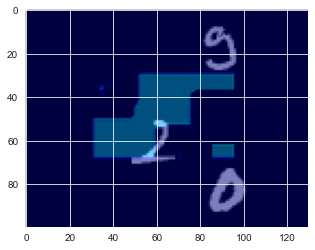

Heatmap for class: 1


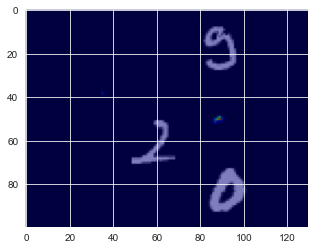

Heatmap for class: 2


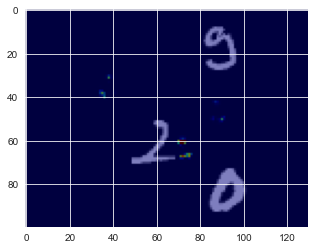

Heatmap for class: 3


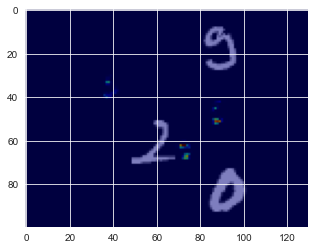

Heatmap for class: 4


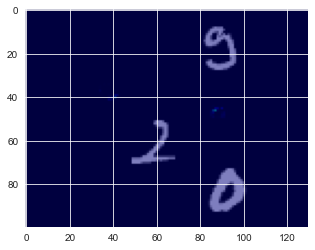

Heatmap for class: 5


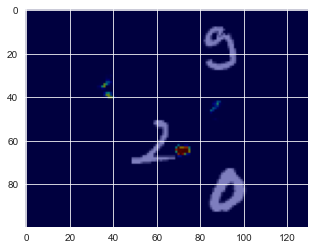

Heatmap for class: 6


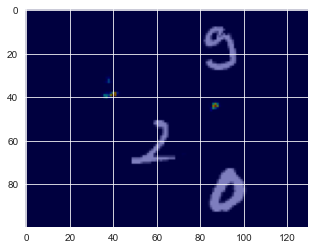

Heatmap for class: 7


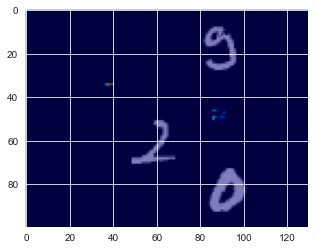

Heatmap for class: 8


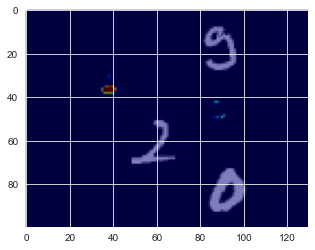

Heatmap for class: 9


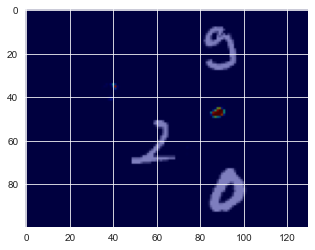

Heatmap for class: 10


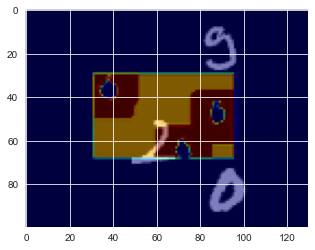

In [107]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)
    plt.show()